<a href="https://colab.research.google.com/github/Hrishik31/Inverse-and-Wiener-Filtering/blob/main/Inverse_and_Wiener_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

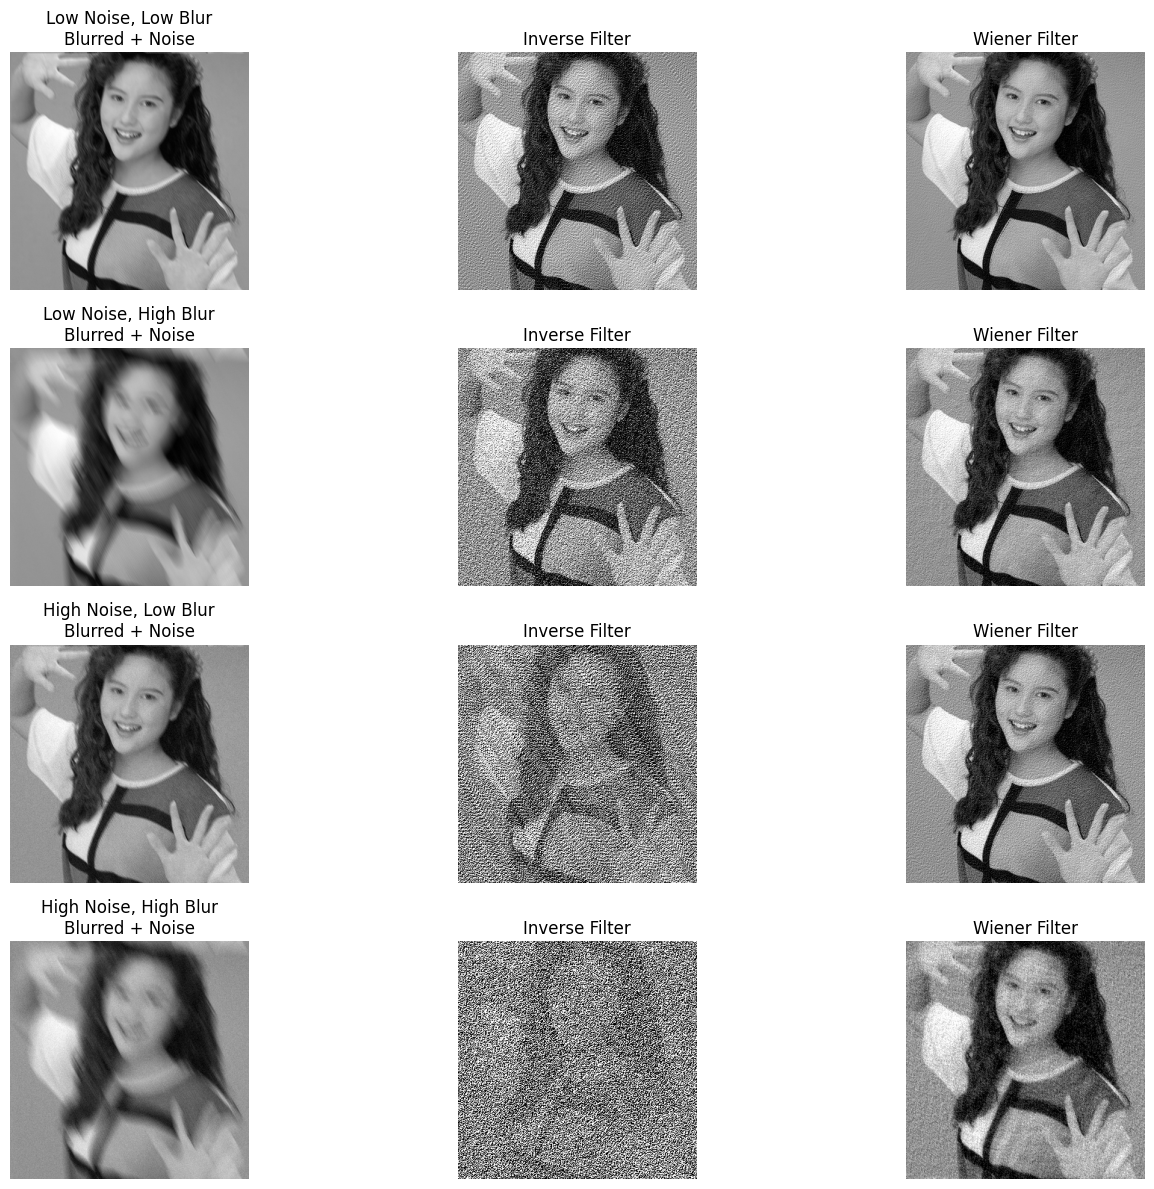


 RESTORATION PERFORMANCE METRICS FOR ALL FOUR CASES 

Case                        Method            MSE         PSNR(dB)    SSIM      
--------------------------------------------------------------------------------
Low Noise, Low Blur         Blurred+Noise     0.00554     22.562      0.9528    
                            Inverse Filter    0.01862     17.301      0.8598    
                            Wiener Filter     0.00139     28.575      0.9885    
--------------------------------------------------------------------------------
Low Noise, High Blur        Blurred+Noise     0.02397     16.204      0.7765    
                            Inverse Filter    0.07252     11.395      0.5692    
                            Wiener Filter     0.00580     22.368      0.9529    
--------------------------------------------------------------------------------
High Noise, Low Blur        Blurred+Noise     0.00596     22.250      0.9495    
                            Inverse Filter    0.20190 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import uniform_filter

# ====================== MAIN SCRIPT ======================

def main():
    # ---------- Load Image ----------
    try:
        img = Image.open('test_image.jpg')  # change filename if needed
        img = np.array(img, dtype=np.float64)
    except:
        print("Image not found! Please provide 'test_image.jpg'")
        return

    # ---------- Convert to Grayscale ----------
    if img.ndim == 3:
        R, G, B = img[:, :, 0], img[:, :, 1], img[:, :, 2]
        I = 0.2989 * R + 0.5870 * G + 0.1140 * B
    else:
        I = img
    I = (I - I.min()) / (I.max() - I.min())
    M, N = I.shape

    # ---------- Define Cases ----------
    cases = [
        {"name": "Low Noise, Low Blur",  "L": 5,  "theta": 30, "noise_sigma": 0.003},
        {"name": "Low Noise, High Blur", "L": 25, "theta": 30, "noise_sigma": 0.003},
        {"name": "High Noise, Low Blur", "L": 5,  "theta": 30, "noise_sigma": 0.02},
        {"name": "High Noise, High Blur","L": 25, "theta": 30, "noise_sigma": 0.02},
    ]

    # ---------- Metric Storage ----------
    results = []

    plt.figure(figsize=(15, 12))
    plot_idx = 1

    for case in cases:
        L = case["L"]
        theta = case["theta"]
        noise_sigma = case["noise_sigma"]
        inv_eps = 1e-3
        img_var = np.var(I)
        noise_var = noise_sigma ** 2
        K = noise_var / max(img_var, 1e-10)

        # ---------- Motion Blur Transfer Function ----------
        H_c = motion_H(M, N, L, theta)
        H = np.fft.ifftshift(H_c)

        # ---------- Blur + Noise ----------
        F = np.fft.fft2(I)
        G_clean = H * F
        g_clean = np.real(np.fft.ifft2(G_clean))
        g = g_clean + noise_sigma * np.random.randn(M, N)

        # ---------- Inverse Filter ----------
        Fhat_inv = inverse_filter(np.fft.fft2(g), H, inv_eps)
        I_inv = np.real(np.fft.ifft2(Fhat_inv))
        I_inv = np.clip(I_inv, 0, 1)

        # ---------- Wiener Filter ----------
        Fhat_wiener = wiener_filter(np.fft.fft2(g), H, K)
        I_wiener = np.real(np.fft.ifft2(Fhat_wiener))
        I_wiener = np.clip(I_wiener, 0, 1)

        # ---------- Metrics ----------
        mse_blur = mse(I, g)
        mse_inv = mse(I, I_inv)
        mse_wiener = mse(I, I_wiener)

        psnr_blur = psnr(I, g)
        psnr_inv = psnr(I, I_inv)
        psnr_wiener = psnr(I, I_wiener)

        ssim_blur = ssim_manual(I, g)
        ssim_inv = ssim_manual(I, I_inv)
        ssim_wiener = ssim_manual(I, I_wiener)

        results.append({
            "case": case["name"],
            "mse_blur": mse_blur, "psnr_blur": psnr_blur, "ssim_blur": ssim_blur,
            "mse_inv": mse_inv, "psnr_inv": psnr_inv, "ssim_inv": ssim_inv,
            "mse_wiener": mse_wiener, "psnr_wiener": psnr_wiener, "ssim_wiener": ssim_wiener
        })

        # ---------- Plot ----------
        plt.subplot(4, 3, plot_idx); plt.imshow(g, cmap='gray')
        plt.title(f"{case['name']}\nBlurred + Noise"); plt.axis('off')
        plt.subplot(4, 3, plot_idx+1); plt.imshow(I_inv, cmap='gray')
        plt.title("Inverse Filter"); plt.axis('off')
        plt.subplot(4, 3, plot_idx+2); plt.imshow(I_wiener, cmap='gray')
        plt.title("Wiener Filter"); plt.axis('off')
        plot_idx += 3

    plt.tight_layout()
    plt.show()

    # ---------- Print Metrics ----------
    print("\n" + "=" * 80)
    print(" RESTORATION PERFORMANCE METRICS FOR ALL FOUR CASES ")
    print("=" * 80)
    print(f"\n{'Case':<28}{'Method':<18}{'MSE':<12}{'PSNR(dB)':<12}{'SSIM':<10}")
    print("-" * 80)
    for r in results:
        print(f"{r['case']:<28}{'Blurred+Noise':<18}{r['mse_blur']:<12.5f}{r['psnr_blur']:<12.3f}{r['ssim_blur']:<10.4f}")
        print(f"{'':<28}{'Inverse Filter':<18}{r['mse_inv']:<12.5f}{r['psnr_inv']:<12.3f}{r['ssim_inv']:<10.4f}")
        print(f"{'':<28}{'Wiener Filter':<18}{r['mse_wiener']:<12.5f}{r['psnr_wiener']:<12.3f}{r['ssim_wiener']:<10.4f}")
        print("-" * 80)


# ====================== HELPER FUNCTIONS ======================

def motion_H(M, N, L, theta):
    a = L * np.cos(np.deg2rad(theta))
    b = L * np.sin(np.deg2rad(theta))
    U, V = freqgrid_centered(M, N)
    P = a * U + b * V
    S = np.ones_like(P)
    nz = P != 0
    S[nz] = np.sin(np.pi * P[nz]) / (np.pi * P[nz])
    H_c = S * np.exp(-1j * np.pi * P)
    return H_c

def freqgrid_centered(M, N):
    u = np.arange(-M//2, M//2) / M
    v = np.arange(-N//2, N//2) / N
    V, U = np.meshgrid(v, u)
    return U, V

def inverse_filter(G, H, eps):
    Fhat = np.zeros_like(G)
    mask = np.abs(H) > eps
    Fhat[mask] = G[mask] / H[mask]
    return Fhat

def wiener_filter(G, H, K):
    denom = np.abs(H)**2 + K
    W = np.conj(H) / denom
    Fhat = W * G
    return Fhat

# ---------- Metrics ----------
def mse(I1, I2):
    return np.mean((I1 - I2) ** 2)

def psnr(I1, I2):
    m = mse(I1, I2)
    if m == 0:
        return float('inf')
    return 10 * np.log10(1.0 / m)

def ssim_manual(X, Y):
    mu_x = np.mean(X)
    mu_y = np.mean(Y)
    sigma_x = np.var(X)
    sigma_y = np.var(Y)
    sigma_xy = np.mean((X - mu_x) * (Y - mu_y))
    C1, C2 = 0.01**2, 0.03**2
    ssim = ((2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)) / \
           ((mu_x**2 + mu_y**2 + C1) * (sigma_x + sigma_y + C2))
    return ssim

# ====================== RUN ======================
if __name__ == "__main__":
    main()
